# Visualizing Catalytic Potentials of Glycolytic Regulatory Kinases: Part 1

In this notebook, the three key regulatory kinases of glycolysis are integrated into the glycolytic network as enzyme modules.

Specifically, this notebook example focuses on visualizing the catalytic potential of each individual enzyme when only one enzyme module are integrated into the network in order to reproduce [Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

from os import path

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from mass import Simulation
from mass.io import json
from mass.test import create_test_model
from mass.util import strip_time
from mass.visualization import plot_phase_portrait, plot_time_profile

All models for this example have already been constructed based on <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> and can be found [here](https://github.com/SBRG/MASSpy/tree/master/documentation_builder/notebooks/models).

## Phase Portraits of Catalytic Potentials for Individual Enzymes
The following cell reproduces [Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>

Successfully loaded MassModel 'Glycolysis_Hb_PFK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.


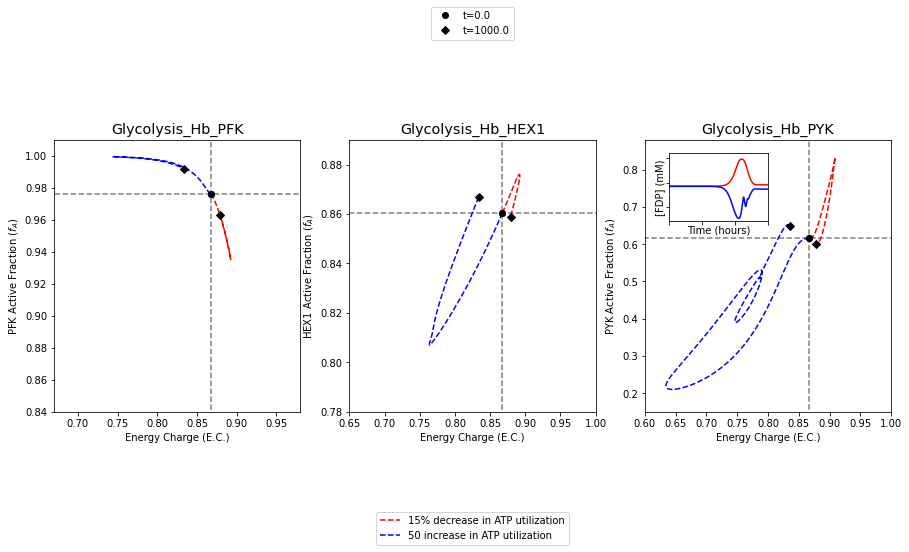

In [2]:
# Create filepath
filepath = path.realpath(path.relpath("../models"))
# Create list of model IDs
model_ids = ["Glycolysis_Hb_PFK",
             "Glycolysis_Hb_HEX1",
             "Glycolysis_Hb_PYK"]
# Define perturbations
perturbations = [
    {"kf_ATPM": "kf_ATPM * 0.85"},
    {"kf_ATPM": "kf_ATPM * 1.50"}]
# Define colors and legend labels
colors = ["red", "blue"]
labels = ["15% decrease", "50 increase"]

# Define axes limits
xy_limits = { 
    "PFK":  [(0.67, 0.98), (0.84, 1.01)],
    "HEX1": [(0.65, 1.00), (0.78, 0.89)],
    "PYK":  [(0.60, 1.00), (0.15, 0.88)]}

# Define helper functions to make aggregate solutions
def make_energy_charge_solution(conc_sol):
    conc_sol.make_aggregate_solution(
        aggregate_id="energy_charge",
        equation="(atp_c + 0.5 * adp_c) / (atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)
    
def make_active_fraction_solution(model, conc_sol, enzyme):
    enzyme = model.enzyme_modules.get_by_id(enzyme)
    active = enzyme.enzyme_module_forms_categorized.get_by_id(
        enzyme.id + "_Active")
    conc_sol.make_aggregate_solution(
        aggregate_id="active_fraction",
        equation="({0}) / ({1})".format(
            " + ".join([e.id for e in active.members]),
             str(strip_time(enzyme.enzyme_concentration_total_equation))),
        variables=enzyme.enzyme_module_forms, update=True)

# Create figure and flatten axes into a list
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()
# Create inset axes
ax_inset = axes[-1].inset_axes([0.1, 0.7, 0.4, 0.25])
ax_inset.tick_params(labelbottom=False, labelleft=False)

# Iterate through models and axes instances
for i, (model_id, ax) in enumerate(zip(model_ids, axes)):
    # Load model and simulation
    model = json.load_json_model(path.join(filepath, model_id + ".json"))
    sim = Simulation(model, verbose=True)
    
    # Get ID of enzyme module in model
    enzyme_id = model.id.split("_")[-1]
    
    # Ensure models are in steady state and make aggregate solutions
    conc_sol, flux_sol = sim.find_steady_state(
        model, strategy="simulate", update_values=True, tfinal=1e4)
    make_energy_charge_solution(conc_sol)
    make_active_fraction_solution(model, conc_sol, enzyme_id)
    
    # Plot steady state lines
    ax.plot([conc_sol["energy_charge"]] * 2, [-0.1, 1.1],
            color="grey", linestyle="--")
    ax.plot([-0.1, 1.1], [conc_sol["active_fraction"]] * 2,
            color="grey", linestyle="--")
        
    # Initialize legend arguments
    legend = None
    time_points_legend = None
    # Iterate through ATP perturbations
    for j, perturbation in enumerate(perturbations):
        # Simulate model with perturbation and make aggregate solutions
        conc_sol, flux_sol = sim.simulate(
            model, time=(0, 1000), perturbations=perturbation)
        make_energy_charge_solution(conc_sol)
        make_active_fraction_solution(model, conc_sol, enzyme_id)
        
        # Set legends on the middle plot only
        if i == 1:
            legend = (labels[j] + " in ATP utilization", "lower outside")
            time_points_legend = "upper outside"

        # Get x and y axes limits
        xlimits, ylimits = xy_limits[enzyme_id]

        # Make phase portrait
        plot_phase_portrait(
            conc_sol, x="energy_charge", y="active_fraction",
            ax=ax, legend=legend,                  # Set axes and legend
            xlim=xlimits, ylim=ylimits,            # Axes limits
            xlabel="Energy Charge (E.C.)",         # Axes labels
            ylabel=enzyme_id + " Active Fraction ($f_{A}$)",
            title=(model.id, {"size": "x-large"}), # Title
            linestyle="--", color=colors[j],       # Line color and style
            annotate_time_points="endpoints",      # Annotate time points
            annotate_time_points_color="black",
            annotate_time_points_legend=time_points_legend)
        
        # Plot time profile of FDP on the inset axes
        if i == 2:
            # Plot FDP time profile
            plot_time_profile(
                conc_sol, observable="fdp_c", ax=ax_inset,
                plot_function="semilogx",
                xlim=(1e-6, 1000), ylim=(0.002, 0.016),
                xlabel="Time (hours)", ylabel="[FDP] (mM)",
                color=colors[j])

## Steps to Reproduce Figure

In this section, the steps for reproducing [Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> are outlined below in an expanded workflow.

### Setup

The first step is to load the models and ensure they exist in a steady state.

In [3]:
filepath = path.realpath(path.relpath("../models"))
models_and_simulations = {}
for model_id in ["Glycolysis_Hb_PFK",
                 "Glycolysis_Hb_HEX1",
                 "Glycolysis_Hb_PYK"]:
    model = json.load_json_model(path.join(filepath, model_id + ".json"))
    simulation = Simulation(model, verbose=True)
    simulation.find_steady_state(model, strategy="simulate",
                                 update_values=True, tfinal=1e4)
    models_and_simulations[model] = simulation

Successfully loaded MassModel 'Glycolysis_Hb_PFK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.


When the `EnzymeModule` objects were created, the active forms of the enzyme was categorized and placed in a group. This will make creating the solution for the active fraction of the enzyme significantly easier.

In [4]:
for model in models_and_simulations:
    # Get the ID of the enzyme module
    e_mod = model.id.split("_")[-1]
    # Get the enzyme module
    e_mod = model.enzyme_modules.get_by_id(e_mod)
    # Get the active group from the categorized enzyme module forms
    active = e_mod.enzyme_module_forms_categorized.get_by_id(
        "_".join((e_mod.id, "Active")))

    print("Enzyme: " + e_mod.id)
    print("Group ID: " + active.id)
    print("# of members: {0}\n".format(len(active.members)))

Enzyme: PFK
Group ID: PFK_Active
# of members: 15

Enzyme: HEX1
Group ID: HEX1_Active
# of members: 4

Enzyme: PYK
Group ID: PYK_Active
# of members: 20



Because aggregate solutions for the adenylate energy charge and enzyme active fractions will need to be created multiple times, smaller "helper" functions are defined to facilate this process. A list containing enzyme IDs is also defined in the order in which the models were stored.

In [5]:
def make_energy_charge_solution(conc_sol):
    conc_sol.make_aggregate_solution(
        aggregate_id="energy_charge",
        equation="(atp_c + 0.5 * adp_c) / (atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)
    return
    
def make_active_fraction_solution(model, conc_sol, enzyme_id):
    # Get the relevant enzyme module
    e_mod = model.enzyme_modules.get_by_id(enzyme_id)

    # Get active group
    active = e_mod.enzyme_module_forms_categorized.get_by_id(
        enzyme_id + "_Active")

    # Create string representing sum of active enzyme forms
    active_eq = " + ".join([e.id for e in active.members])

    # Create string representing sum of all enzyme forms
    total_eq  = str(strip_time(e_mod.enzyme_concentration_total_equation))

    # Make aggregate solution
    conc_sol.make_aggregate_solution(
        aggregate_id="active_fraction",
        equation="({0}) / ({1})".format(active_eq, total_eq),
        variables=e_mod.enzyme_module_forms, update=True)
    return

enzyme_ids = [model.id.split("_")[-1] for model in models_and_simulations]
enzyme_ids

['PFK', 'HEX1', 'PYK']

The figure and axes instances are created using **matplotlib**. The figure size is set as 15 x 5 to create three square plots in a single row. Each plot will be have a size of 5 x 5.

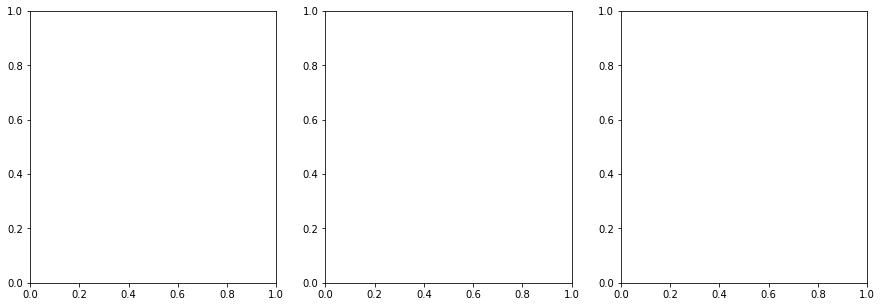

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()

Lists containing tuples for the x-axis and y-axis limits are also created. They are placed in a dictionary where the enzyme module IDs are the `dict` keys.

In [7]:
# Values are formatted as [(xmin, xmax), (ymin, ymax)]
xy_limits = { 
    "PFK":  [(0.67, 0.98), (0.84, 1.01)],
    "HEX1": [(0.65, 1.00), (0.78, 0.89)],
    "PYK":  [(0.60, 1.00), (0.15, 0.88)]}

### Plot steady state lines
The steady state values are plotted as straight lines to visually indicate where the steady state lies.

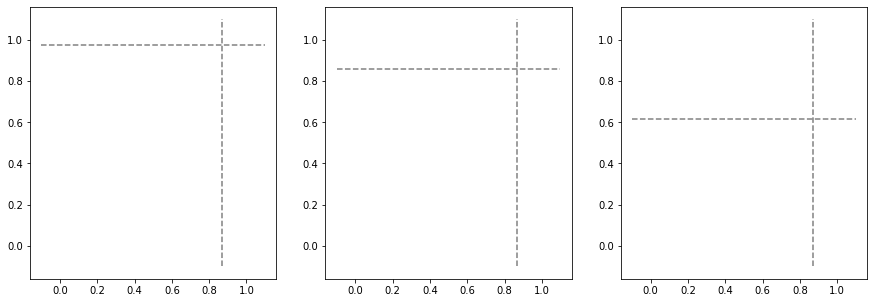

In [8]:
for i, (model, sim) in enumerate(models_and_simulations.items()):
    # Get axes to plot on
    ax = axes[i]
    # Get ID of enzyme module in model
    enzyme_id = enzyme_ids[i]
    # Get MassSolution objects containing steady state values
    conc_sol_ss, flux_sol_ss = sim.find_steady_state(
        model, strategy="simulate", update_values=True, tfinal=1e4)
    
    # Make an aggregate solution for the energy charge
    make_energy_charge_solution(conc_sol_ss)
    # Plot a vertical line at the steady steady value
    ax.plot([conc_sol_ss["energy_charge"]] * 2,
            [-0.1, 1.1],
            color="grey", linestyle="--")
    
    # Make an aggregate solution for the active fraction
    make_active_fraction_solution(model, conc_sol_ss, enzyme_id)
    # Plot a horizontal line at the steady steady value
    ax.plot([-0.1, 1.1],
            [conc_sol_ss["active_fraction"]] * 2,
            color="grey", linestyle="--")
fig

### Plot catalytic potentials for 15% decrease in ATP utilization

The first set of results to plot on the figure are the results obtained from simulating the models with a 15% decrease in ATP utilization. This behavior is mimicked by perturbing the rate constant for ATP use to be 0.85 times its original value. The color "red" will be used to represent these results.

Legends are also created for perturbations and the annotated time points, placed below and above the middle plot, respectively.

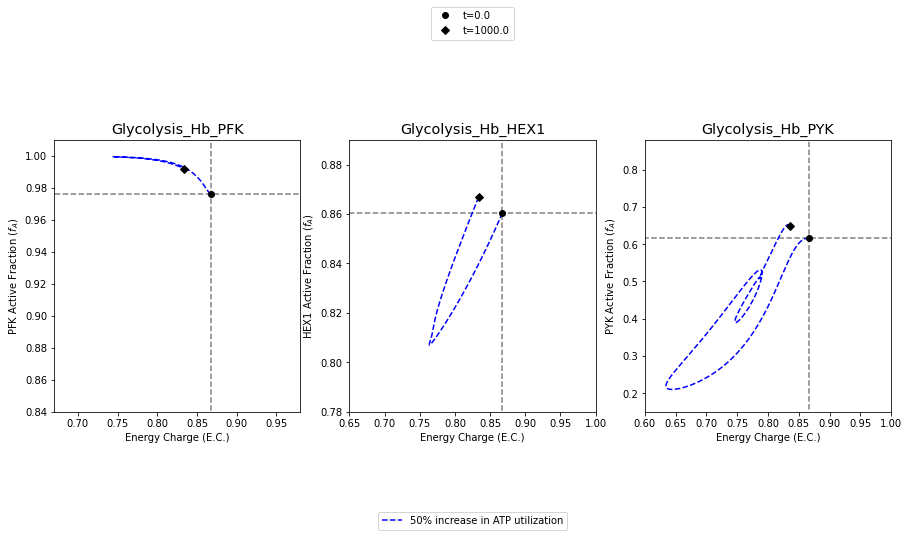

In [9]:
for i, (model, sim) in enumerate(models_and_simulations.items()):
    # Get axes to plot on
    ax = axes[i]
    # Get ID of enzyme module in model
    enzyme_id = enzyme_ids[i]
    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"});
    
    # Make an aggregate solution for the energy charge
    make_energy_charge_solution(conc_sol)
    
    # Make an aggregate solution for the active fraction
    make_active_fraction_solution(model, conc_sol, enzyme_id)

    # Place legend on middle plot only
    if i == 1:
        legend = ("50% increase in ATP utilization", "lower outside")
        time_points_legend = "upper outside"
    else:
        legend = None
        time_points_legend = None

    # Get x and y axes limits
    xlimits, ylimits = xy_limits[enzyme_id]
    # Make phase portrait
    plot_phase_portrait(
        conc_sol, x="energy_charge", y="active_fraction",
        ax=ax, legend=legend,                  # Axes instance and legend
        xlim=xlimits, ylim=ylimits,            # Axes limits
        xlabel="Energy Charge (E.C.)",         # Axes labels
        ylabel=enzyme_id + " Active Fraction ($f_{A}$)",
        title=(model.id, {"size": "x-large"}), # Title
        linestyle="--", color="blue",          # Line color and style
        annotate_time_points="endpoints",      # Annotate time points
        annotate_time_points_color="black",
        annotate_time_points_legend=time_points_legend,
    ) 
fig 

### Plot catalytic potentials for 50% increase in ATP utilization

The second set of results to plot on the figure are the results obtained from simulating the models with a 50% increase in ATP utilization. This behavior is mimicked by perturbing the rate constant for ATP use to be 1.5 times its original value. The color "blue" will be used to represent these results.

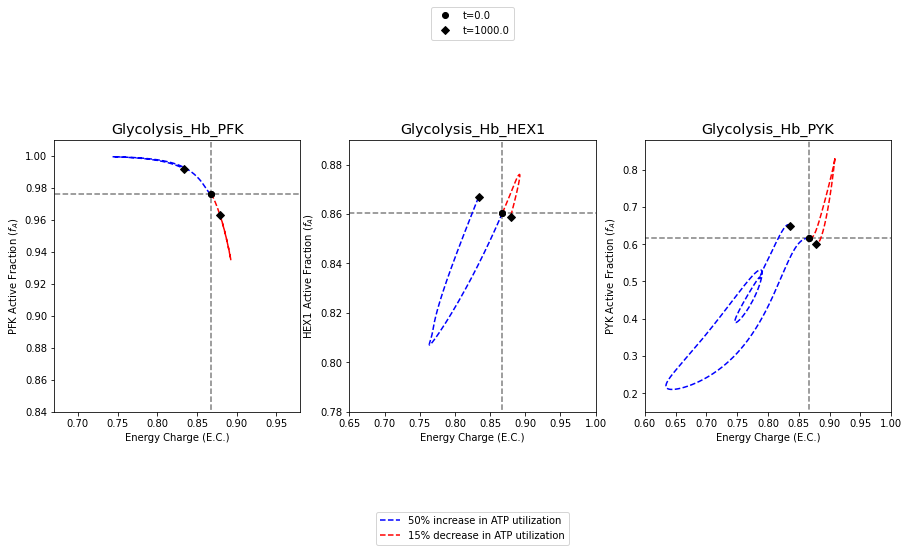

In [10]:
for i, (model, sim) in enumerate(models_and_simulations.items()):
    # Get axes to plot on
    ax = axes[i]
    # Get ID of enzyme module in model
    enzyme_id = enzyme_ids[i]

    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 0.85"});
    
    # Make an aggregate solution for the energy charge
    make_energy_charge_solution(conc_sol)
    
    # Make an aggregate solution for the active fraction
    make_active_fraction_solution(model, conc_sol, enzyme_id)

    # Place legend on middle plot only
    if i == 1:
        legend = ("15% decrease in ATP utilization", "lower outside")
        time_points_legend = "upper outside"
    else:
        legend = None
        time_points_legend = None
    # Get x and y axes limits
    xlimits, ylimits = xy_limits[enzyme_id]
    # Make phase portrait
    plot_phase_portrait(
        conc_sol, x="energy_charge", y="active_fraction",
        ax=ax, legend=legend,                  # Axes instance and legend
        xlim=xlimits, ylim=ylimits,            # Axes limits
        xlabel="Energy Charge (E.C.)",         # Axes labels
        ylabel=enzyme_id + " Active Fraction ($f_{A}$)",
        title=(model.id, {"size": "x-large"}), # Title
        linestyle="--", color="red",           # Line color and style
        annotate_time_points="endpoints",      # Annotate time points
        annotate_time_points_color="black",
        annotate_time_points_legend=time_points_legend,
    ) 
fig 

### Time profile of FDP concentration
The plot of FDP concentration in the upper left quadrant of the plot for the catalytic potential of PYK is created.

#### Create inset axes
First, the inset axes instance is created and the axes tick labels are removed:

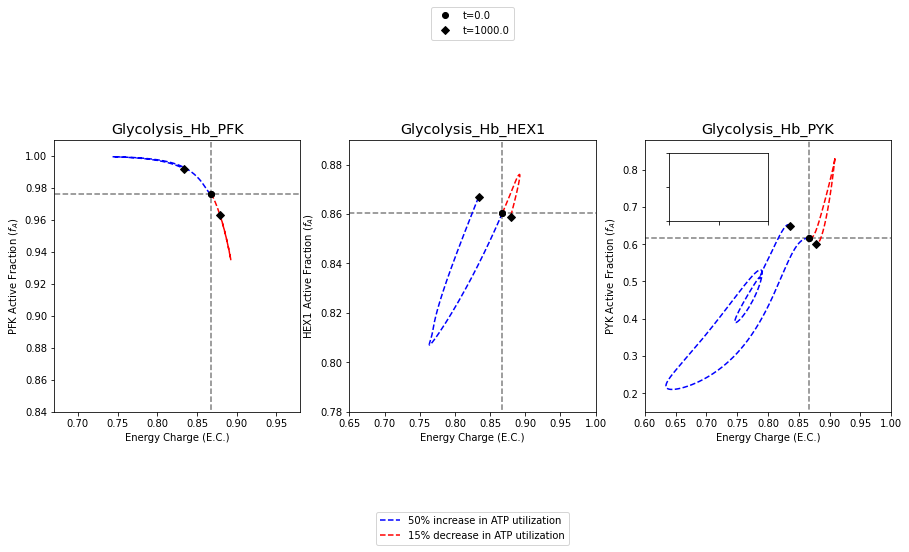

In [11]:
# Get the axes instance
right_ax = axes[-1]
ax_inset = right_ax.inset_axes([0.1, 0.7, 0.4, 0.25])
ax_inset.tick_params(labelbottom=False, labelleft=False)
fig

#### Plot 15% decrease in ATP utilization

The model with the PYK enzyme module is simulated with a 15% decrease in ATP utilization, and the results are plotted. 

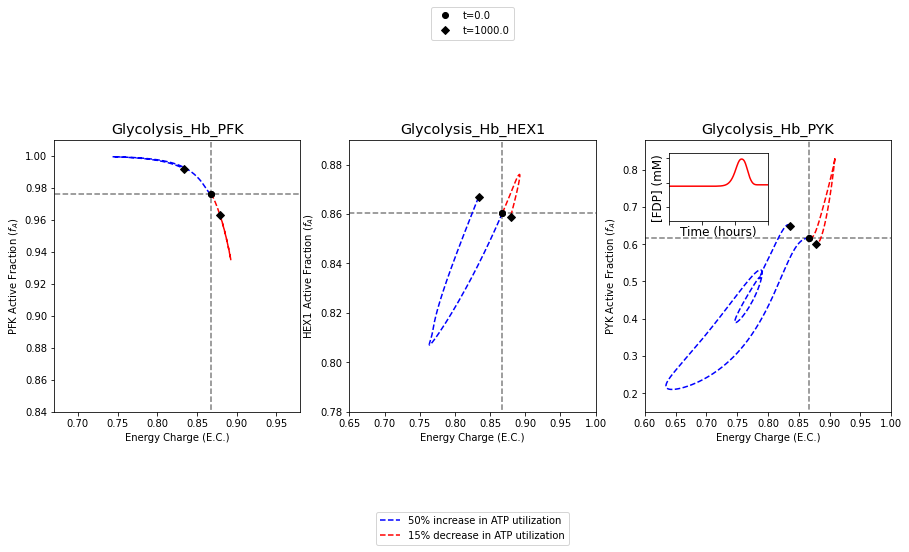

In [12]:
for model, sim in models_and_simulations.items():
    # Only interested in the third model
    if model.id != "Glycolysis_Hb_PYK":
        continue
    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 0.85"});
    
    # Plot FDP time profile
    plot_time_profile(
        conc_sol, observable="fdp_c", ax=ax_inset,
        plot_function="semilogx",
        xlim=(1e-6, 1000), ylim=(0.002, 0.016),
        xlabel=("Time (hours)", {"size": "large"}),
        ylabel=("[FDP] (mM)", {"size": "large"}),
        color="red")
fig

#### Plot 50% increase in ATP utilization

In a similar fashion, the results of simulating the model with a 50% increase in ATP utilization are plotted.

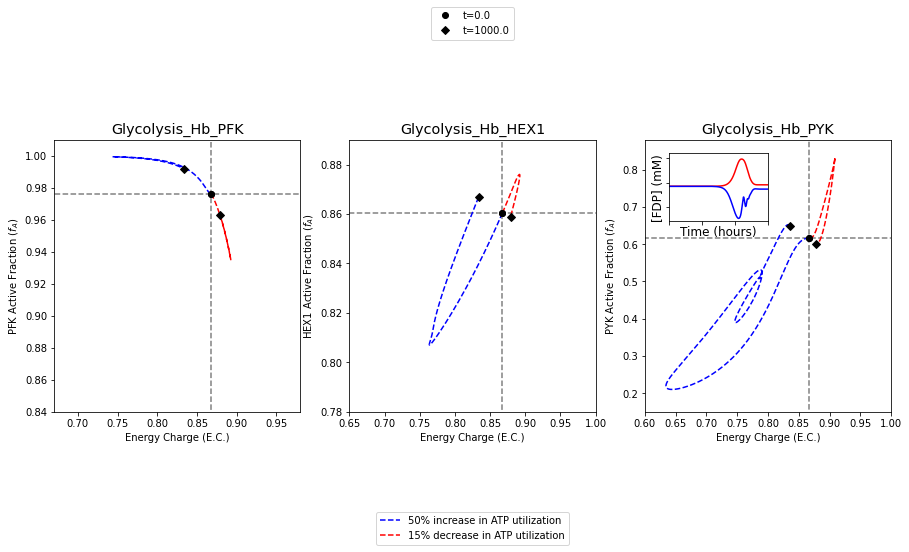

In [13]:
for model, sim in models_and_simulations.items():
    # Only interested in the third model
    if model.id != "Glycolysis_Hb_PYK":
        continue
    # Simulate model with a 50% increase in ATP utilization
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, 1000),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"});
    
    # Plot FDP time profile
    plot_time_profile(
        conc_sol, observable="fdp_c", ax=ax_inset,
        plot_function="semilogx",
        xlim=(1e-6, 1000), ylim=(0.002, 0.016),
        xlabel=("Time (hours)", {"size": "large"}),
        ylabel=("[FDP] (mM)", {"size": "large"}),
        color="blue")
fig

[Figure 2](https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1006356.g002) of <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> has been reproduced.